In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import glob
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import Fourier
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import umap.umap_ as umap
import skfda
# from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from umap import UMAP
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
from skfda.exploratory.visualization import FPCAPlot
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler, RobustScaler, SplineTransformer

from itertools import product
import numpy as np
from scipy.interpolate import interp1d, Akima1DInterpolator, splrep, CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, LSQUnivariateSpline 
from scipy.interpolate import BSpline, make_interp_spline, make_smoothing_spline, PchipInterpolator, make_lsq_spline
from skfda.exploratory.depth import ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot, MagnitudeShapePlot

if not os.path.isdir('figures'):
    os.makedirs('figures')

In [2]:
def label_season(year):
    if year == 2020:
        return 'Season 10'
    if year == 2022:
        return 'Season 13'
    if year == 2023:
        return 'Season 15'
    return None


def add_days_after_planting(df, day_of_planting='2022-11-11'):
    day_of_planting = pd.to_datetime(day_of_planting)
    # df['days_after_planting'] = (pd.to_datetime(df['date']) - day_of_planting).dt.days
    df.loc[:, 'days_after_planting'] = (pd.to_datetime(df['date']) - day_of_planting).dt.days

    return df


def add_class_column(df):
    class_dict = {
        "Batavia": ["Iceberg", "La Brillante"],
        "Butterhead": ["Margarita", "Ninja"],
        "Crisphead": ["Emperor", "Salinas"],
        "Green leaf": ["Grand Rapids", "Salad Bowl"],
        "Red leaf": ["Lolla Rosa", "Merlot"],
        "Romaine": ["Green Towers", "Valmaine"]
    }

    def get_class(genotype):
        for class_name, genotypes in class_dict.items():
            if genotype in genotypes:
                return class_name
        return None

    df['class'] = df['genotype'].apply(get_class)
    return df


def fix_treatments(df):

    df = df[~((df['season'] == 'Season 10') & (df['treatment'] == 2))]
    df.loc[df['season'] == 'Season 10', 'treatment'] = df.loc[df['season'] == 'Season 10', 'treatment'].replace(3, 2)

    return df


def create_fpca_dataset(df, targets, trait, season, group_column):

    sample = df[df['variable']==trait]
    sample = sample[sample['season']==season]
    sample.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    groups = sample[group_column].drop_duplicates().values
    print(f'Number of individual plants: {len(groups)}')
    # days = sample['days_after_planting'].unique()
    # days = np.arange(days.min(), days.max() + 1)
    # days.sort()
    day_counts = sample['days_after_planting'].value_counts()
    min_groups = len(groups) * 0.5  # at least 10% of groups
    days = day_counts[day_counts >= min_groups].index
    # days = np.arange(days.min(), days.max() + 1)
    # days.sort()
    days = days.sort_values()
    print(days)

    data_matrix = []
    valid_groups = []
    treatments = []
    crop_types = []
    origin_countries = []
    population_types = []
    sub_crops = []
    lettuce_types = []
    lettuce_types2 = []
    colors = []

    for i, group in enumerate(groups):
        
        group_data = sample[sample[group_column] == group]
        treatment = group_data['treatment'].unique()[0]
        crop_type = group_data['crop_type'].unique()[0]
        origin_country = group_data['origin_country'].unique()[0]
        population_type = group_data['population_type'].unique()[0]
        sub_crop = group_data['sub_crop'].unique()[0]
        lettuce_type = group_data['Type of Lettuce'].unique()[0]
        lettuce_type2 = group_data['Lettuce type'].unique()[0]
        color = group_data['Colour'].unique()[0]

        group_data = group_data[['days_after_planting', 'value']].groupby('days_after_planting', as_index=False).median()
        group_data['value'] = pd.to_numeric(group_data['value'], errors='coerce')

        group_data = group_data.sort_values('days_after_planting')
        x = group_data['days_after_planting'].values
        y = group_data['value'].values

        # f = Akima1DInterpolator(x, y)
        f = interp1d(x, y, kind='slinear', fill_value='extrapolate') #, bounds_error=False) #
        # f = CubicSpline(x, y, extrapolate=True)
        # f = PchipInterpolator(x, y, extrapolate=True)
        interpolated_values = f(days)
    
        interpolated_values = np.where(interpolated_values < 0, 0, interpolated_values)
        
        if not np.isnan(interpolated_values).any():
            
            data_matrix.append(interpolated_values)
            valid_groups.append(group)

            treatments.append(treatment)
            crop_types.append(crop_type)
            origin_countries.append(origin_country)
            population_types.append(population_type)
            sub_crops.append(sub_crop)
            lettuce_types.append(lettuce_type)
            lettuce_types2.append(lettuce_type2)
            colors.append(color)

    # Convert list to numpy array
    data_matrix = np.array(data_matrix)

    fd = skfda.FDataGrid(data_matrix, days)
    fd.argument_names = ["Days after planting"]
    fd.coordinate_names = [trait]
    
    print(f'Number of valid individual plants: {len(valid_groups)}')
    
    dataset = {
        'data': fd,
        'target': valid_groups,
        'treatment': treatments,
        'crop_type': crop_types,
        'origin_country': origin_countries,
        'population_type': population_types,
        'sub_crop': sub_crops,
        'Type of Lettuce': lettuce_types,
        'Lettuce type': lettuce_types2,
        'Colour': colors
    }
    
    return dataset


def run_fpca_updated(fd, targets, figure_name):

    fd.plot()
    plt.tight_layout()
    plt.savefig(os.path.join(figure_name, 'curves_raw.png'), dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
    plt.show()
    plt.close()

    basis = skfda.representation.basis.BSplineBasis(n_basis=4, order=3)
    basis_fd = fd.to_basis(basis)
    basis_fd.plot()
    plt.tight_layout()
    plt.savefig(os.path.join(figure_name, 'curves_fit.png'), dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
    plt.show()
    plt.close()
    
    basis_fd.coefficients[basis_fd.coefficients < 0] = 0

    # Use 4 components in the FPCA
    fpca = FPCA(n_components=4, centering=True)
    fpca.fit(basis_fd)
    
    # Plot the components with a legend for each PC
    fpca.components_.plot()
    
    # Get the explained variance by each PC
    exp_var = fpca.explained_variance_ratio_
    
    # Add a legend for each PC with the explained variance
    plt.legend([f'fPC1 - {exp_var[0]*100:.2f}%', f'fPC2 - {exp_var[1]*100:.2f}%', f'fPC3 - {exp_var[2]*100:.2f}%', f'fPC4 - {exp_var[3]*100:.2f}%'])
    # plt.legend([r'$\it{f}$PC1 - {exp_var[0]*100:.2f}%', r'$\it{f}$PC2 - {exp_var[1]*100:.2f}%', r'$\it{f}$PC3 - {exp_var[2]*100:.2f}%', r'$\it{f}$PC4 - {exp_var[3]*100:.2f}%'])
    # plt.legend([r'$\mathit{f}$PC1 - {exp_var[0]*100:.2f}%', r'$\mathit{f}$PC2 - {exp_var[1]*100:.2f}%', r'$\mathit{f}$PC3 - {exp_var[2]*100:.2f}%', r'$\mathit{f}$PC4 - {exp_var[3]*100:.2f}%'])

    plt.axhline(0, color='black', linestyle=':')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_name, 'fpca_components.png'), dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
    plt.show()
    plt.close()

    scores = fpca.transform(basis_fd)

    fpca_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
    return fpca_df, basis_fd, exp_var



def get_passport_data():

    # Open passport data
    ps = pd.read_excel('https://cgn.websites.wur.nl/Website/downloads/download/Cnr06Passport.xlsx', sheet_name='data')\
                .rename(columns={'ACCNAME': 'genotype',
                                'SUBTAXA': 'subtaxa',
                                'ORIGCTY': 'origin_country'})\
                [['genotype', 'subtaxa', 'origin_country', 'SAMPSTAT', '*SUBCROP']]
    ps['SAMPSTAT'] = ps['SAMPSTAT'].astype(str)
    ps['*SUBCROP'] = ps['*SUBCROP'].astype(str).str.zfill(4)
    # ps = ps.set_index('SAMPSTAT')
    ps['subtaxa'] = ps['subtaxa'].str.replace('group ', '')
    ps['subtaxa'] = ps['subtaxa'].str.replace(' Lettuce', '')
    ps['subtaxa'] = ps['subtaxa'].str.strip()
    ps['genotype'] = ps['genotype'].str.strip()
    ps = ps.rename(columns={'SAMPSTAT': 'Code', '*SUBCROP': 'sub_crop_code'})
    #ps = ps.dropna(subset=['genotype'])


    # Get sample status
    sub = pd.read_excel('https://cgn.websites.wur.nl/Website/downloads/download/Cnr06Passport.xlsx', sheet_name='sample status')
    sub['Code'] = sub['Code'].astype(float).astype(str)

    # Combine the two dataframes
    result = ps.merge(sub, on='Code')#, how='left') #, how='outer')#, left_index=True, right_index=True)#.dropna()
    result = result.rename(columns={'Description': 'population_type',
                           'subtaxa': 'crop_type'}).reset_index(drop=True)

    #### ADDED
    # Get sub crop
    sub = pd.read_excel('https://cgn.websites.wur.nl/Website/downloads/download/Cnr06Passport.xlsx', sheet_name='sub crop')
    sub['Code'] = sub['Code'].astype(str).str.zfill(4)
    sub = sub.rename(columns={'Code': 'sub_crop_code'})

    # Combine the two dataframes
    result = result.merge(sub, on='sub_crop_code')#, how='left') #, how='outer')#, left_index=True, right_index=True)#.dropna()
    result = result.rename(columns={
        'Description': 'sub_crop'
    }).reset_index(drop=True)
    
    return result


def dataset_to_dataframe(dataset, basis_fd=None):
    
    if basis_fd:
        # data_matrix = basis_fd['data'].data_matrix
        data_matrix = basis_fd.coefficients
    else:
        data_matrix = dataset['data'].data_matrix

    # Assuming 'data_matrix' is your 3D numpy array
    data_matrix_2d = data_matrix.reshape(data_matrix.shape[0], -1)

    df = pd.DataFrame(data_matrix_2d).T

    df.columns = dataset['target']
    df = df.melt().rename(columns={'variable': 'plant_name'})
    # df[['plant_name', 'treatment']] = df['plant_name'].str.split('_', expand=True)
    # df['plant_name'] = df['plant_name'].str.split('_', expand=True)

    # Assuming 'df' is your DataFrame and 'dataset' is your dictionary
    additional_info_df = pd.DataFrame({
        'plant_name': dataset['target'],
        'treatment': dataset['treatment'],
        'crop_type': dataset['crop_type'],
        'origin_country': dataset['origin_country'],
        'population_type': dataset['population_type'],
        'sub_crop': dataset['sub_crop'],
        'Type of Lettuce': dataset['Type of Lettuce'],
        'Lettuce type': dataset['Lettuce type'],
        'Colour': dataset['Colour']
    })

    # Set 'genotype' as the index for easy concatenation
    # additional_info_df.set_index('genotype', inplace=True)

    df = df.merge(additional_info_df, on=['plant_name'])

    # Add 'days_after_planting' to the DataFrame
    for plant_name in df['plant_name'].unique():
        df.loc[df['plant_name'] == plant_name, 'days_after_planting'] = dataset['data'].grid_points[0]

    return df

# Define a function to set the labels with the explained variance
def set_labels(ax, pc1_var, pc2_var):
    ax.set_xlabel(f'fPC1 - {pc1_var*100:.2f}%')
    ax.set_ylabel(f'fPC2 - {pc2_var*100:.2f}%')

def add_units(variable):
    if variable == 'Height':
        return 'Height (cm)'
    elif variable == 'Hull Volume':
        return 'Hull Volume (cm³)'
    else:
        return variable

In [3]:
sns.set_context('talk', font_scale=0.9, rc={"lines.linewidth": 1.6}) #paper, notebook, talk, poster
#'poster', font_scale=0.5

# Get the 'Paired' color palette
palette = sns.color_palette("Paired")

# # Define the RGB values for a lighter shade of brown
# lighter_brown = (205/255 + 0.1, 133/255 + 0.1, 63/255 + 0.1)  # RGB values for lighter brown

# # Replace yellow with light brown in the palette
# palette[10] = lighter_brown

sns.set_palette(palette=palette)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
# Open data
df = pd.concat([pd.read_csv(csv) for csv in glob.glob('phenotype_data_by_date/*_individual_plant.csv')], ignore_index=True)
# print(len(df))

# df = pd.concat([pd.read_csv(csv) for csv in glob.glob('phenotype_data_by_date/*_individual_plant.csv')])
# print(len(df))
# df = pd.concat([pd.read_csv(csv) for csv in glob.glob('phenotype_data_by_date/*_plot_average.csv')])

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year from 'date'
df['year'] = df['date'].dt.year

# Apply the function to the 'year' column to create the 'season' column
df['season'] = df['year'].apply(label_season)

# Fix genotype name 
df['genotype'] = df['genotype'].str.replace('_', ' ').str.replace('-', '')

# Add days after planting
df_s10 = add_days_after_planting(df=df[df['season']== 'Season 10'], day_of_planting='2019-11-13')
df_s13 = add_days_after_planting(df=df[df['season']== 'Season 13'], day_of_planting='2021-12-02')
df_s15 = add_days_after_planting(df=df[df['season']== 'Season 15'], day_of_planting='2022-11-15')
df = pd.concat([df_s10, df_s13, df_s15], ignore_index=True)

# Clean columns
df['genotype'] = df['genotype'].str.strip()

# Add market types
df = add_class_column(df=df)

df['class'] = df['class'].str.strip()

# Extract lines representative of market types
line_list = ['Emperor',
'Grand Rapids',
'Green Towers',
'Iceberg',
'La Brillante',
'Lolla Rosa',
'Margarita',
'Merlot',
'Ninja',
'Salad Bowl',
'Salinas',
'Valmaine']

# df = df[df['genotype'].isin(line_list)]

# Clean data frame for plotting
df = df.drop('index', axis=1)
df = fix_treatments(df=df)

# Name the treatments
df['treatment'] = df['treatment'].map({
    1: 'WW',
    2: 'WL'
})

df = df[~df['genotype'].isna()]

passport_data = get_passport_data()
passport_data['genotype'] = passport_data['genotype'].str.strip()
# df['genotype'] = df['genotype'].str.strip()

df = passport_data.merge(df, on='genotype', how='right')

#######
# Group by 'season' and 'genotype', and count the number of unique seasons for each genotype
df['season_count'] = df.groupby('genotype')['season'].transform('nunique')

# Get the total number of unique seasons
total_seasons = df['season'].nunique()

# Keep only the rows where 'season_count' is equal to 'total_seasons'
df = df[df['season_count'] == total_seasons]

# You can drop the 'season_count' column afterwards if you don't need it
df = df.drop(columns=['season_count'])
#######

#Extract specific treatment
df = df[df['treatment']=='WL']
df = df[df['season']=='Season 15']

df = df[~df['plant_name'].isin(['Grand_Rapids_63', 'Salinas_161', 'Merlot_62', 'Salad_Bowl_20', 'Salad_Bowl_169', 'Salinas_85',
                                'Emperor_152', 'Valmaine_2', 'La_Brillante_54', 'Iceberg_27', 'Grand_Rapids_62', 'Salad_Bowl_74', 
                                'Emperor_137', 'Emperor_156', 'Salad_Bowl_52', 'Salad_Bowl_107', 'Salad_Bowl_5', 'Valmaine_20'])]

df = df.set_index(['genotype', 'date', 'year', 'season', 'days_after_planting', 'class', 'treatment', 
                   'crop_type', 'origin_country', 'population_type', 'sub_crop',
                   'plant_name'])

# Traditional

In [5]:
phenotype_list = [
    'height', 'hull_volume',

    'amplitude_heat_0',
    'amplitude_heat_1',
    'amplitude_heat_2',

    'amplitude_persistence_image_0',
    'amplitude_persistence_image_1',
    'amplitude_persistence_image_2',

    'amplitude_wasserstein_0',
    'amplitude_wasserstein_1',
    'amplitude_wasserstein_2',

    'number_points_0',
    'number_points_1',
    'number_points_2',

    'persistence_entropy_0',
    'persistence_entropy_1',
    'persistence_entropy_2'
]

plot_df = df[phenotype_list]

# Take vector norm
plot_df['number_points'] = plot_df[['number_points_0', 'number_points_1', 'number_points_2']].apply(lambda x: np.linalg.norm(x), axis=1)
plot_df['amplitude_persistence_image'] = plot_df[['amplitude_persistence_image_0', 'amplitude_persistence_image_1', 'amplitude_persistence_image_2']].apply(lambda x: np.linalg.norm(x), axis=1)
plot_df['amplitude_heat'] = plot_df[['amplitude_heat_0', 'amplitude_heat_1', 'amplitude_heat_2']].apply(lambda x: np.linalg.norm(x), axis=1)
plot_df['amplitude_wasserstein'] = plot_df[['amplitude_wasserstein_0', 'amplitude_wasserstein_1', 'amplitude_wasserstein_2']].apply(lambda x: np.linalg.norm(x), axis=1)
plot_df['persistence_entropy'] = plot_df[['persistence_entropy_0', 'persistence_entropy_1', 'persistence_entropy_2']].apply(lambda x: np.linalg.norm(x), axis=1)

plot_df = plot_df[['height', 'hull_volume', 'number_points', 'amplitude_heat']]
                #    'amplitude_persistence_image', 'amplitude_wasserstein', 'persistence_entropy']]

plot_df = plot_df.melt(ignore_index=False).reset_index()
plot_df['variable'] = plot_df['variable'].str.replace('_0', '').str.replace('_', ' ').str.title()
plot_df = plot_df.sort_values(['class', 'genotype'])
plot_df['variable'] = plot_df['variable'].apply(add_units)
len(plot_df)

184876

In [6]:
labels = pd.read_excel('https://data.cyverse.org/dav-anon/iplant/projects/phytooracle/season_10_lettuce_yr_2020/season10_lettuce_field_book_types.xlsx',
              sheet_name='Types').drop(['Unnamed: 0', 'Source', 'Source #2', 'Notes'], axis=1).rename(columns={'Variety name': 'genotype'})

labels['Type of Lettuce'] = labels['Type of Lettuce'].str.replace('Lettuce', '').str.strip()
labels['Type of Lettuce'] = labels['Type of Lettuce'].str.replace(' /', '/').str.title()
labels['genotype'] = labels['genotype'].str.replace('_', ' ')
labels['Lettuce type'] = labels['Lettuce type'].str.title()

plot_df = plot_df.merge(labels, on='genotype')

In [7]:
plot_df['genotype'].nunique()

132

In [8]:
GROUP = 'crop_type' #'Lettuce type' #'Type of Lettuce' #'class' 'Colour' #

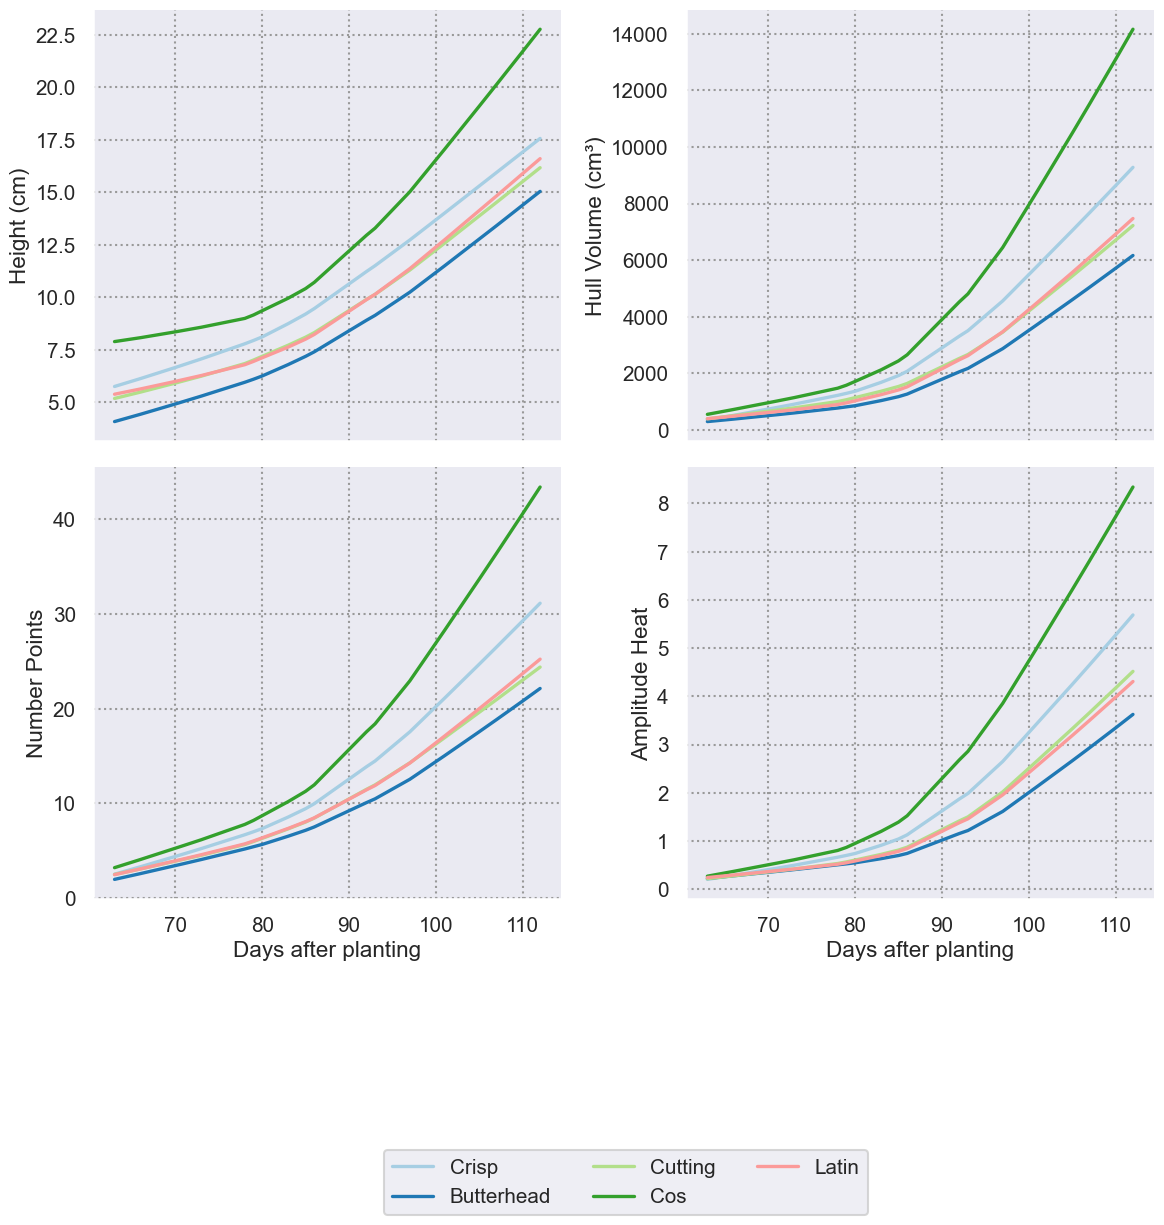

In [9]:
g = sns.lmplot(
    x='days_after_planting',
    y='value',
    hue=GROUP,
    # col='season',
    col='variable',
    col_wrap=2,
    data=plot_df,
    lowess=True,
    scatter=False,
    # kind='line',
    facet_kws={'sharex': True, 'sharey': False}
)

g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

# Set y-axis title for each subplot
for col_name, ax in g.axes_dict.items():
    ax.set_ylabel(col_name)

for ax in g.axes.flat:
    ax.set_title('')

# Increase space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Set x-axis title
g.set_xlabels('Days after planting')

# Move legend to bottom center
sns.move_legend(g, "lower center", bbox_to_anchor=(.53, -0.24), ncol=3, title=None, frameon=True)

# Adjust the padding around the edge of the figure
plt.tight_layout()

plt.savefig('figures/trait_traditional.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Number of individual plants: 2226
Index([ 63,  66,  69,  70,  71,  73,  78,  79,  80,  83,  85,  86,  92,  93,
        97, 100, 101, 105, 107, 110, 112],
      dtype='int64', name='days_after_planting')
Number of valid individual plants: 2226


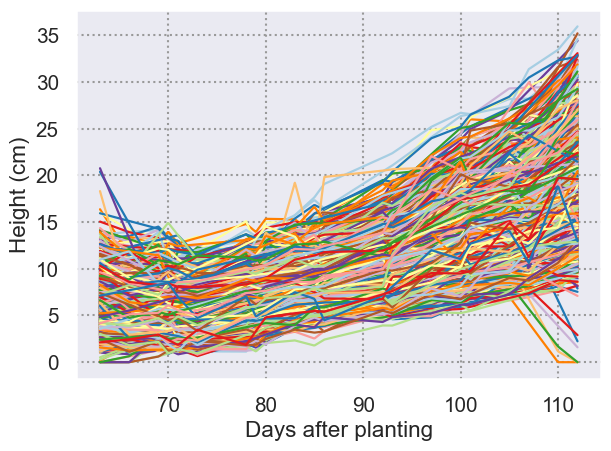

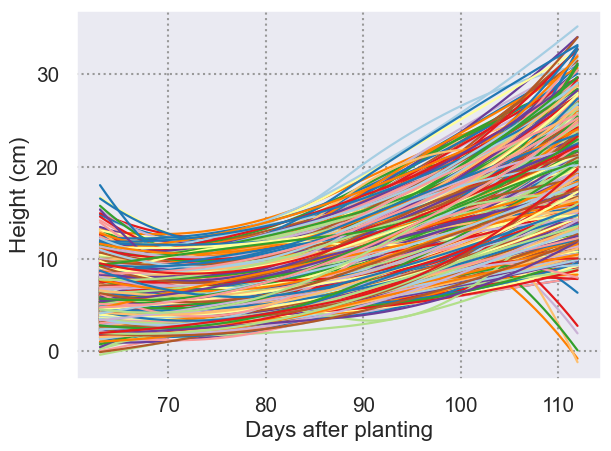

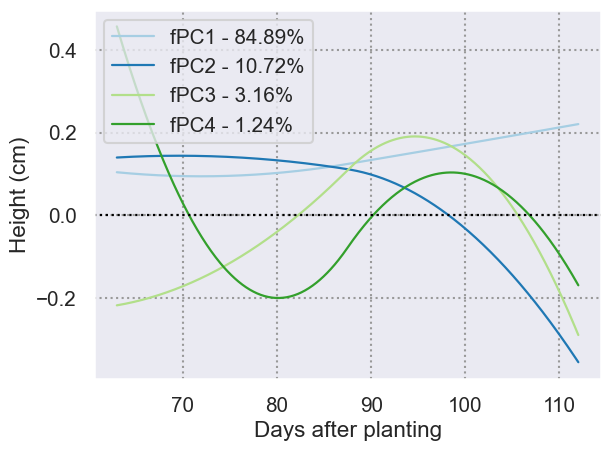

Number of individual plants: 2226
Index([ 63,  66,  69,  70,  71,  73,  78,  79,  80,  83,  85,  86,  92,  93,
        97, 100, 101, 105, 107, 110, 112],
      dtype='int64', name='days_after_planting')
Number of valid individual plants: 2226


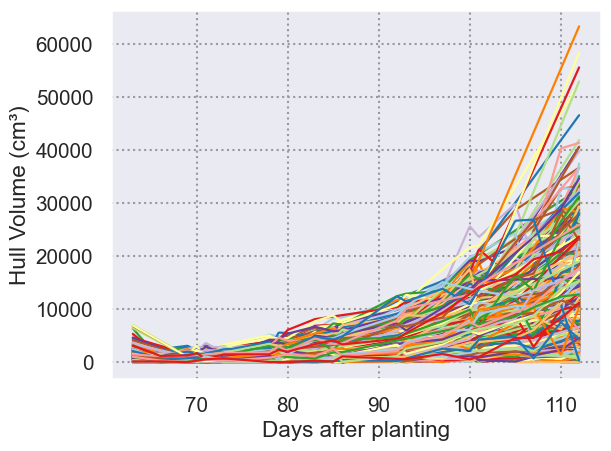

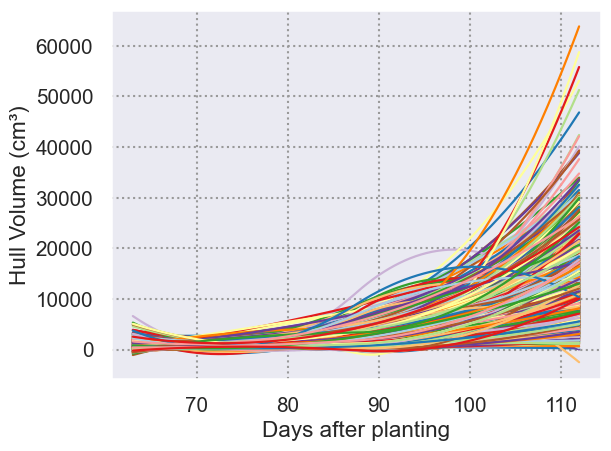

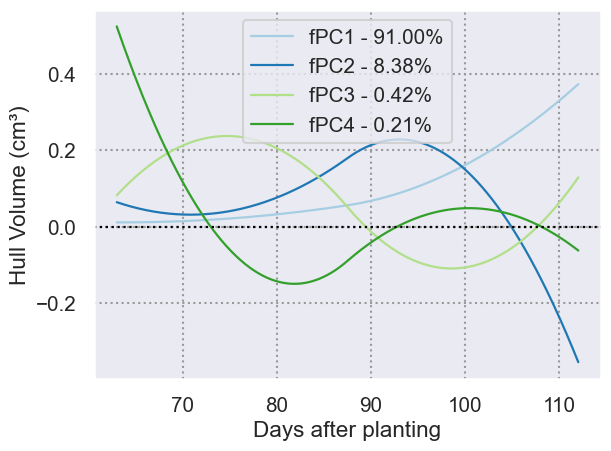

Number of individual plants: 2226
Index([ 63,  66,  69,  70,  71,  73,  78,  79,  80,  83,  85,  86,  92,  93,
        97, 100, 101, 105, 107, 110, 112],
      dtype='int64', name='days_after_planting')
Number of valid individual plants: 2226


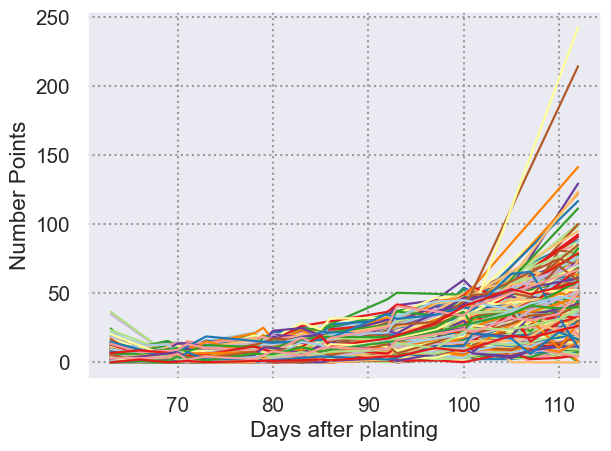

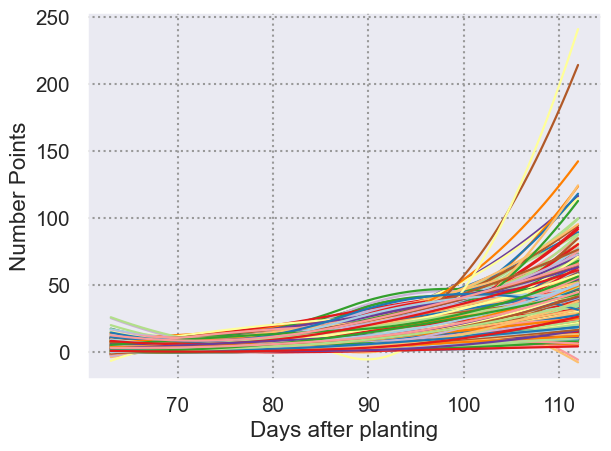

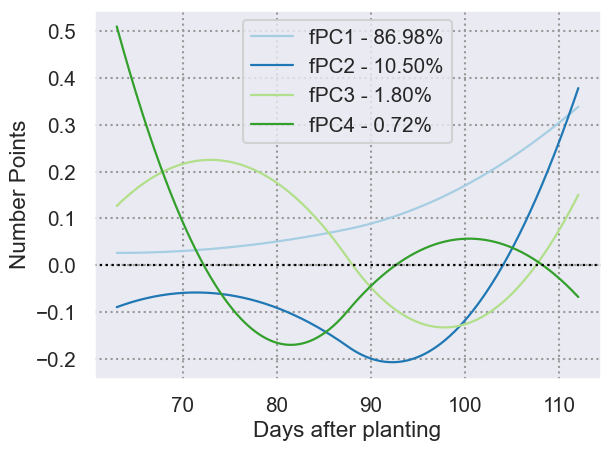

Number of individual plants: 2226
Index([ 63,  66,  69,  70,  71,  73,  78,  79,  80,  83,  85,  86,  92,  93,
        97, 100, 101, 105, 107, 110, 112],
      dtype='int64', name='days_after_planting')
Number of valid individual plants: 2226


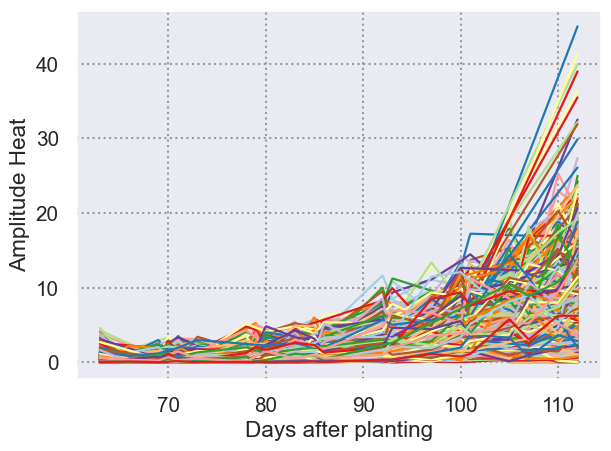

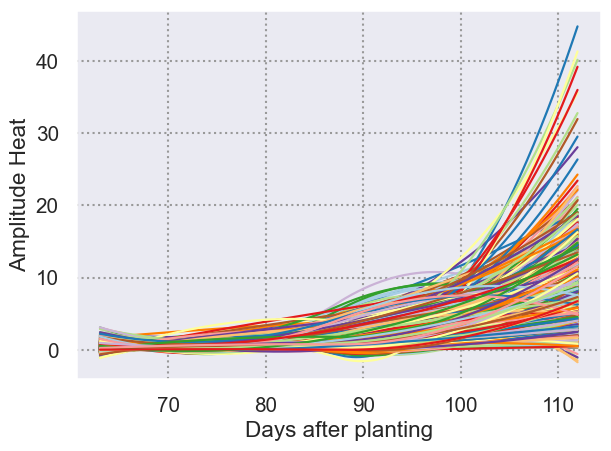

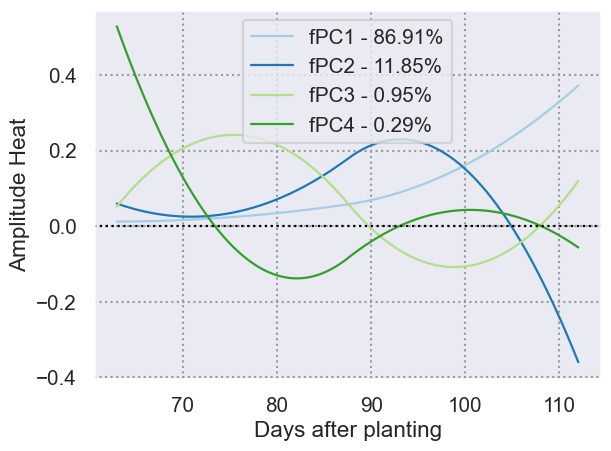

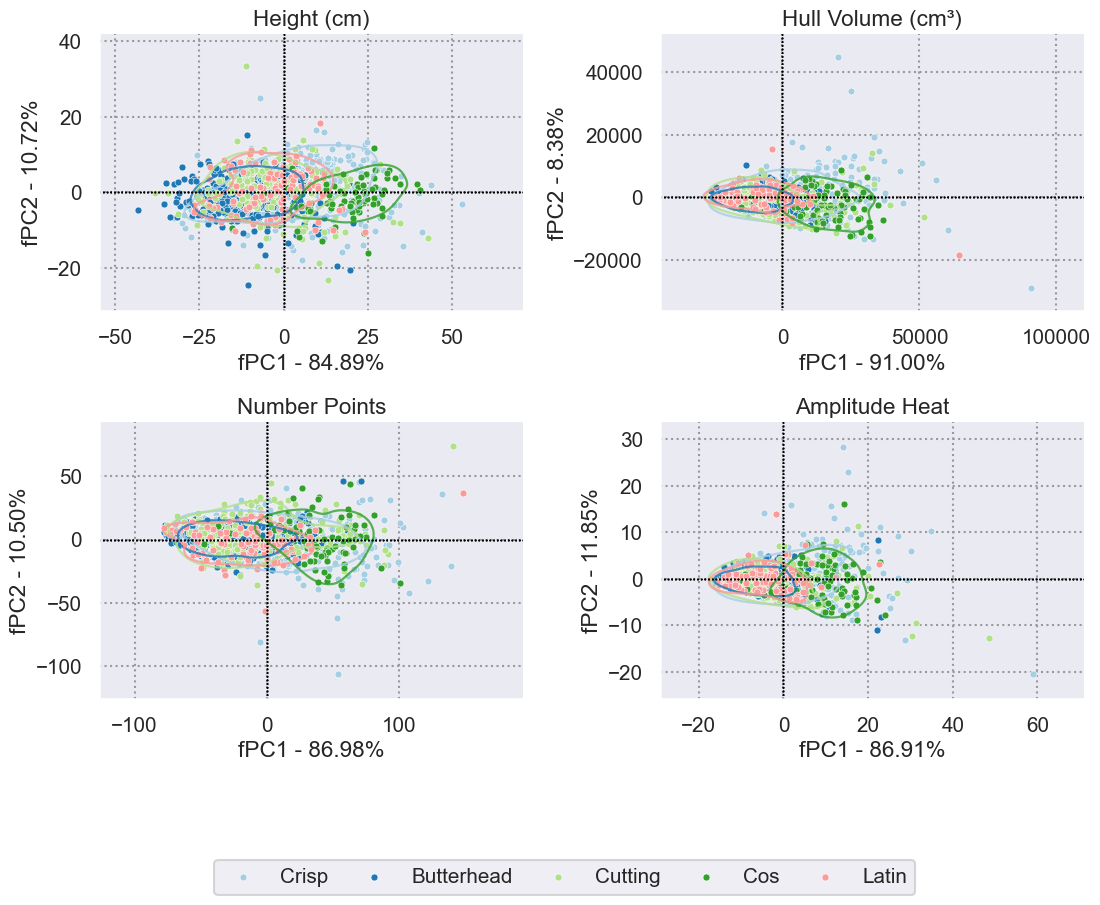

In [10]:
# Get the unique seasons and variables
seasons = plot_df['season'].unique()
variables = plot_df['variable'].unique()

# Get all combinations of seasons and variables
combinations = list(product(seasons, variables))

# Initialize an empty DataFrame to store the FPCA results
fpca_results = pd.DataFrame()

# Initialize a dictionary to store the explained variance for each variable
exp_var_dict = {}

# Run the functions for each combination
for season, variable in combinations:

    out_dir = os.path.join('figures', season, variable.lower().replace(' ', '_'))
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    
    dataset = create_fpca_dataset(
        df=plot_df,
        targets=['genotype', 'treatment', 'date', 'year', 'season', 'days_after_planting', 'class', 'plant_name'],
        trait=variable,
        season=season,
        group_column='plant_name'
    )

    fpca_df, basis_fd, exp_var = run_fpca_updated(dataset['data'],
                                         targets=dataset['target'],
                                         figure_name=out_dir)
    # fpca_df, basis_fd = run_umap(dataset['data'], targets=dataset['target'])
    # fpca_df, basis_fd = run_aligned_umap(dataset['data'], targets=dataset['target'])
    fit_data = dataset_to_dataframe(dataset) #, basis_fd) 
    fpca_df['genotype'] = dataset['target']
    fpca_df['treatment'] = dataset['treatment']
    fpca_df['crop_type'] = dataset['crop_type']
    fpca_df['origin_country'] = dataset['origin_country']
    fpca_df['population_type'] = dataset['population_type']
    fpca_df['sub_crop'] = dataset['sub_crop']
    fpca_df['Type of Lettuce'] = dataset['Type of Lettuce']
    fpca_df['Lettuce type'] = dataset['Lettuce type']
    fpca_df['Colour'] = dataset['Colour']

    # Add the season and variable to the results
    fpca_df['season'] = season
    fpca_df['variable'] = variable

    # Append the results to the overall results DataFrame
    fpca_results = pd.concat([fpca_results, fpca_df])

    # Save the explained variance to the dictionary
    exp_var_dict[variable] = exp_var

# Reset the index of the results DataFrame
fpca_results.reset_index(drop=True, inplace=True)

fpca_results['genotype'] = fpca_results['genotype'].str.rsplit('_', n=1).str[0].str.replace('_', ' ').str.strip()
fpca_results = add_class_column(df=fpca_results)
# fpca_results = fpca_results.groupby(['class', 'season', 'variable'])[['PC1', 'PC2']].mean().reset_index()

# Define the FacetGrid
g = sns.FacetGrid(fpca_results, col='variable', hue=GROUP, sharex=False, sharey=False, aspect=1.2, height=4, col_wrap=2) #col='season', 

# Map sns.kdeplot to create the density plot with transparency
g = g.map(sns.kdeplot, 'PC1', 'PC2', fill=False, alpha=0.8, levels=1, thresh=.3)

# Map sns.scatterplot to create the scatter plot with smaller points
g = g.map(sns.scatterplot, 'PC1', 'PC2', s=25)

# Add a legend
g.add_legend()

# # Move the legend to bottom center
# plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -1.2), ncol=5)

g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

# Use FacetGrid.map to apply the function to each subplot
for i, ax in enumerate(g.axes.flat):
    variable = g.col_names[i]
    set_labels(ax, exp_var_dict[variable][0], exp_var_dict[variable][1])

# Move legend to bottom center
sns.move_legend(g, "lower center", bbox_to_anchor=(.51, -0.15), ncol=6, title=None, frameon=True, columnspacing=1.2)

# Add vertical and horizontal lines at x=0 and y=0 with specified line width
g = g.map(plt.axhline, y=0, ls=':', c='black', linewidth=1)
g = g.map(plt.axvline, x=0, ls=':', c='black', linewidth=1)

# Adjust the padding around the edge of the figure
plt.tight_layout()

plt.savefig('figures/fpca_traditional.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

In [11]:
# plot_df = plot_df.drop_duplicates(subset=['genotype', 'date', 'year', 'season', 'days_after_planting', 'class', 'treatment', 'crop_type', 'origin_country', 'population_type', 'sub_crop', 'plant_name'])

In [12]:
plot_df = plot_df.drop_duplicates(subset=['genotype', 'date', 'year', 'season', 'days_after_planting', 'class', 'treatment', 'crop_type', 'origin_country', 'population_type', 'sub_crop', 'plant_name', 'variable'])

In [13]:
plot_df = plot_df.pivot(index = ['genotype', 'date', 'year', 'season', 'days_after_planting', 'class', 'treatment', 'crop_type', 'origin_country',
                   'population_type', 'sub_crop', 'plant_name'],
              columns='variable',
              values='value').reset_index()

In [14]:
# Group the DataFrame by 'date'
grouped = plot_df.groupby('days_after_planting')

# Initialize an empty dictionary to store the correlation DataFrames
corr_dfs = {}

# Calculate the correlation for each group and store it in the dictionary
for name, group in grouped:
    corr_dfs[name] = group[['Height (cm)', 'Hull Volume (cm³)', 'Number Points', 'Amplitude Heat']].corr()
                            # 'Amplitude Persistence Image', 'Amplitude Wasserstein', 
                            # 'Persistence Entropy']].corr()

# Now, corr_dfs is a dictionary where the keys are the dates and the values are the corresponding correlation DataFrames

# Convert the dictionary to a DataFrame
df = pd.concat(corr_dfs)

# Melt the DataFrame into a long format
df = df.melt(ignore_index=False, var_name='var2', value_name='correlation')

# Reset index
df.reset_index(inplace=True)

# Rename columns
df.columns = ['date', 'var1', 'var2', 'correlation']

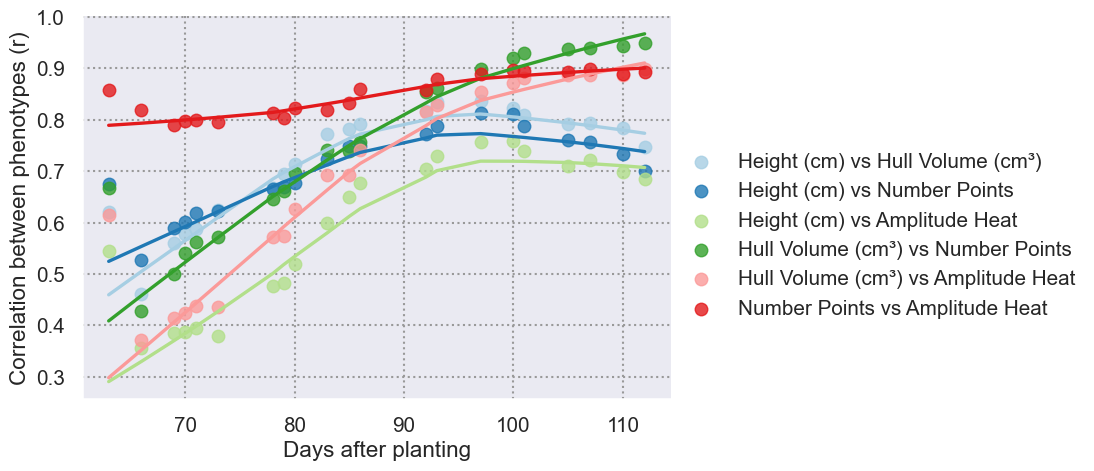

In [15]:
# Create a new DataFrame to store the reshaped data
corr_df = pd.DataFrame()

# Loop through each pair of variables
variables = ['Height (cm)', 'Hull Volume (cm³)', 'Number Points', 'Amplitude Heat']
            #  'Amplitude Persistence Image', 'Amplitude Wasserstein', 'Persistence Entropy']


for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        temp_df = df.loc[(df['var1'] == var1) & (df['var2'] == var2), ['date', 'correlation']]
        temp_df['pair'] = f'{var1} vs {var2}'
        corr_df = pd.concat([corr_df, temp_df])

# Create the plot
plot = sns.lmplot(
    x='date',
    y='correlation',
    hue='pair',
    lowess=True,
    data=corr_df,
    aspect=1.5
)

# Update the labels
plot.set(xlabel="Days after planting", ylabel="Correlation between phenotypes (r)")

# Update the legend title
plot._legend.set_title('')#'Phenotype pair')

# Adjust the padding around the edge of the figure
# plt.tight_layout()

plt.savefig('figures/phenotype_correlations.png', dpi=900, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

# Show the plot
plt.show()

